<br>

I used followed methods<br>

* A custom CNN model with 194,529 trainable parameters
* Splitted train(2549 images) and test set (450 images) <br>
* Used <b>elu</b> activation function during feature extraction
* Used tf.data for input pipeline

## CNN Model Architecture

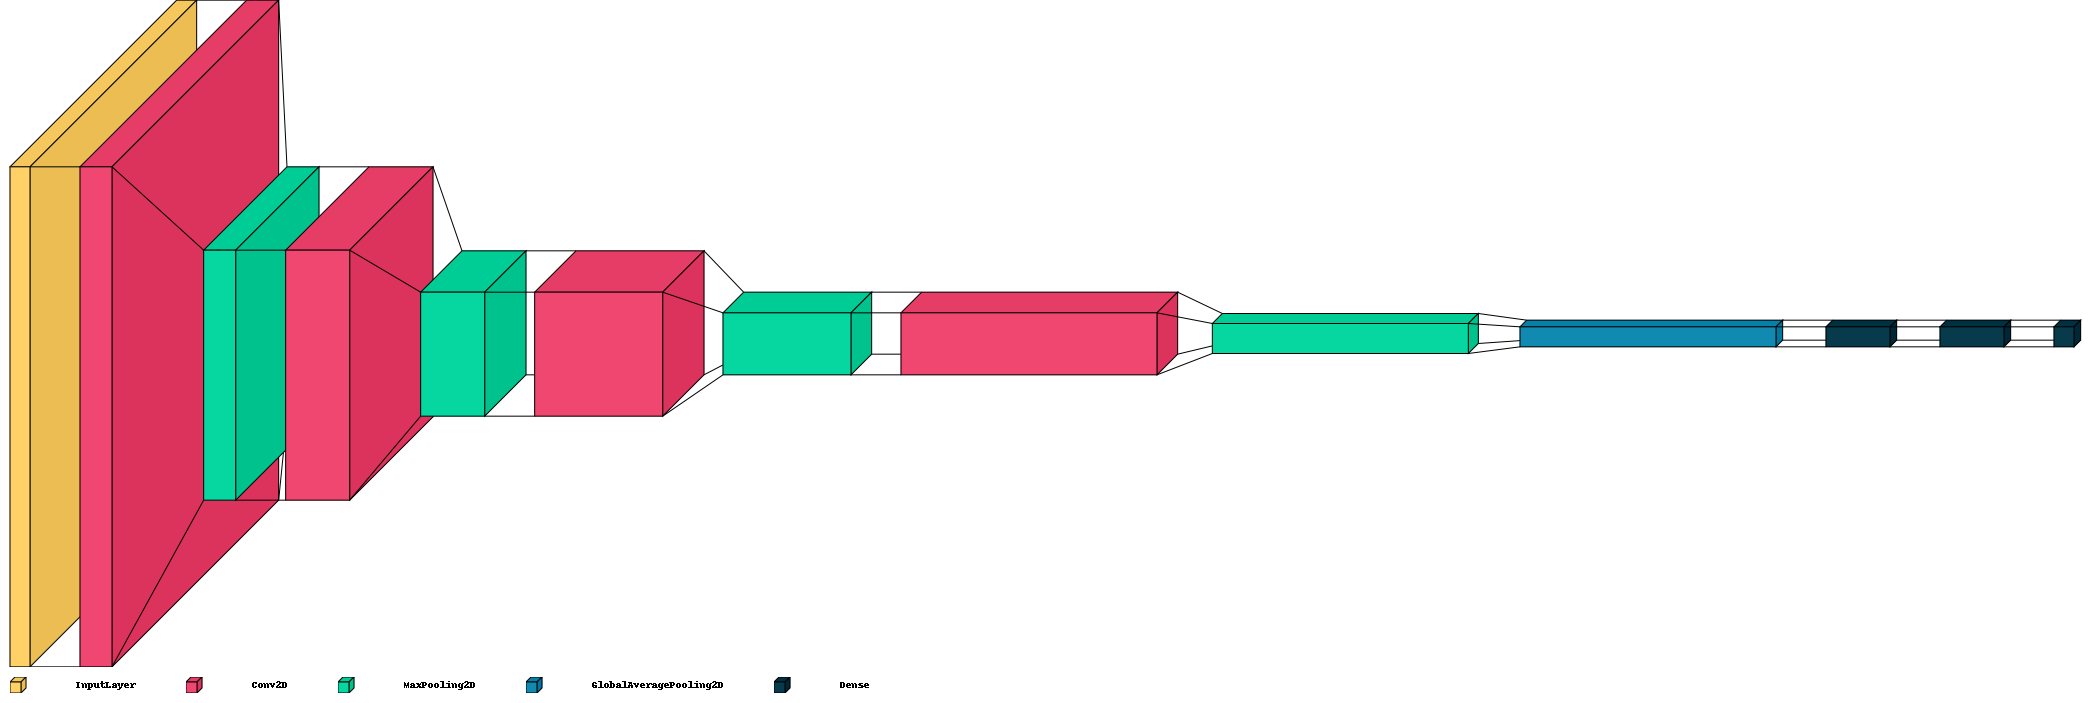



In [1]:
from IPython.display import clear_output
!pip install visualkeras
clear_output()

In [2]:
# Importing dependencies

import os
import random
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
import visualkeras

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, Flatten, GlobalAveragePooling2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 15
BATCH_SIZE = 8

In [3]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = os.listdir(path)
    for i in tqdm(images, desc = 'images' ):
        full_path.append(os.path.join(path, i))
        
    return full_path


data_healthy = create_images_list('/kaggle/input/detection-of-down-syndrome-in-children/healty/healty')
data_down = create_images_list('/kaggle/input/detection-of-down-syndrome-in-children/downSyndorme/downSyndrome')


# look-up table
disease_classes = {0:'healthy', 1 : 'down' }

data_df = pd.concat([  pd.DataFrame({"img" : np.array(data_healthy) , "label": 0 }),
                        pd.DataFrame({"img" : np.array(data_down) , "label": 1 }) ], ignore_index = True)


data_df = shuffle(data_df).reset_index(drop = True)

images:   0%|          | 0/1499 [00:00<?, ?it/s]

images:   0%|          | 0/1500 [00:00<?, ?it/s]

In [4]:
# Creating random 4 sample from a dataframe


def create_img_label_sample(data, index):
    
    img = cv2.imread(data['img'][index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = disease_classes[data_df['label'][index]]
    
    return img, label


def create_random_samples(data):
    
    idx1,idx2,idx3,idx4 =np.random.permutation(data.shape[0])[:4]
    
    fig, axs = plt.subplots(1,4, figsize = (12,5), dpi = 300)
    
    img1, name1 = create_img_label_sample(data, idx1)
    img2, name2 = create_img_label_sample(data, idx2)
    img3, name3 = create_img_label_sample(data, idx3)
    img4, name4 = create_img_label_sample(data, idx4)

    
    axs[0].imshow(img1)
    axs[0].set_title(name1)
    axs[0].axis('off')

    axs[1].imshow(img2)
    axs[1].set_title(name2)
    axs[1].axis('off')

    axs[2].imshow(img3)
    axs[2].set_title(name3)
    axs[2].axis('off')

    axs[3].imshow(img4)
    axs[3].set_title(name4)
    axs[3].axis('off')
    
    plt.show()

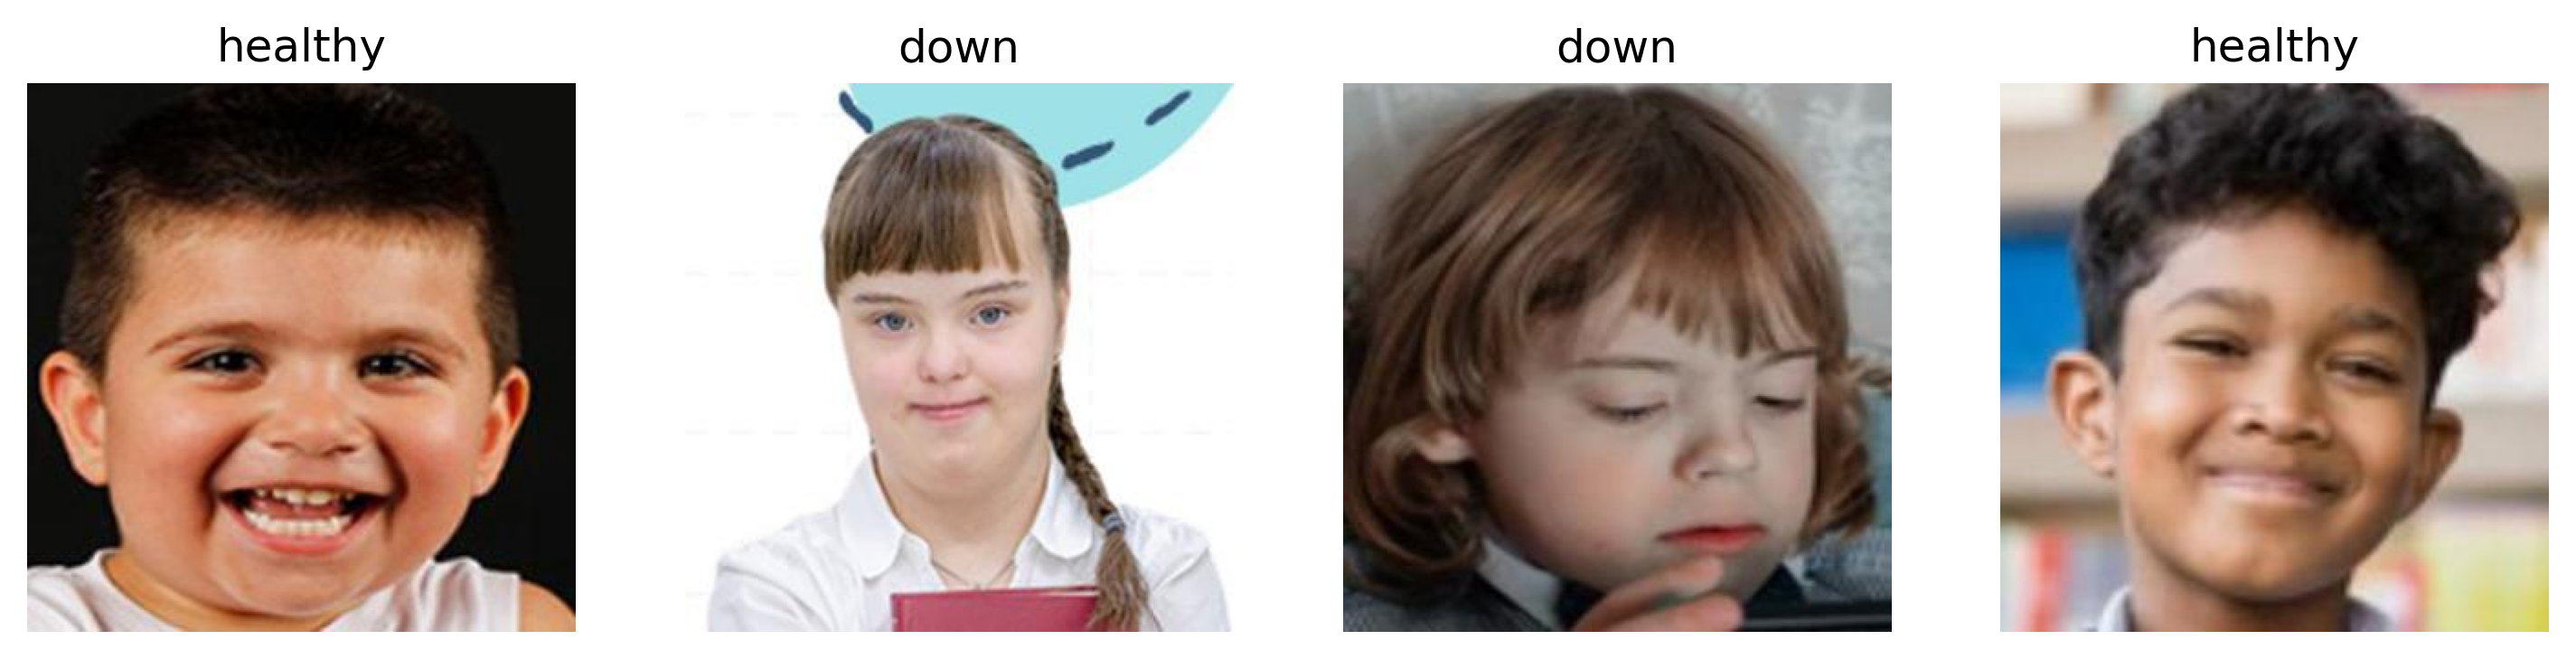

In [5]:
# Random samples

create_random_samples(data_df)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_df['img'], data_df['label'], test_size = 0.15,  random_state = SEED)

print("train images: ", X_train.shape[0])
print("test images: ", X_test.shape[0])

train images:  2549
test images:  450


# <span style="color:#e74c3c;"> Creating </span> Datasets


In [7]:
def img_preprocessing(image, label):
    
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (250,250))
    img = img/255.0
    
    return img, label

In [8]:
# Creating dataset loaders

train_loader = tf.data.Dataset.from_tensor_slices(( X_train, y_train) )
train_dataset = (train_loader.map(img_preprocessing).batch(BATCH_SIZE).shuffle(X_train.shape[0]).prefetch(BATCH_SIZE))

test_loader = tf.data.Dataset.from_tensor_slices(( X_test, y_test) )
test_dataset = (test_loader.map(img_preprocessing).batch(BATCH_SIZE).prefetch(BATCH_SIZE))

# <span style="color:#e74c3c;"> CNN </span> Model


In [9]:
In = Input(shape=(250, 250, 3))

conv2 = Conv2D(32, 2, padding = 'same')(In)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('elu')(conv2)
conv2 = MaxPooling2D(2)(conv2)

conv2 = Conv2D(64, 2, padding = 'same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('elu')(conv2)
conv2 = MaxPooling2D(2)(conv2)


conv2 = Conv2D(128, 2, padding = 'same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('elu')(conv2)
conv2 = MaxPooling2D(2)(conv2)


conv2 = Conv2D(256, 2, padding = 'same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('elu')(conv2)
conv2 = MaxPooling2D(2)(conv2)


pool = GlobalAveragePooling2D()(conv2)
drop = Dropout(0.6)(pool)
dense1 = Dense(64, activation = 'relu')(drop)
dense1 = Dense(64, activation = 'relu')(dense1)
Out = Dense(1, activation = 'sigmoid')(dense1)

model = Model(inputs = In, outputs = Out)

model.compile(optimizer  = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = ['accuracy','AUC','Precision','Recall'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 250, 250, 32)      416       
                                                                 
 batch_normalization (BatchN  (None, 250, 250, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 250, 250, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      8256  

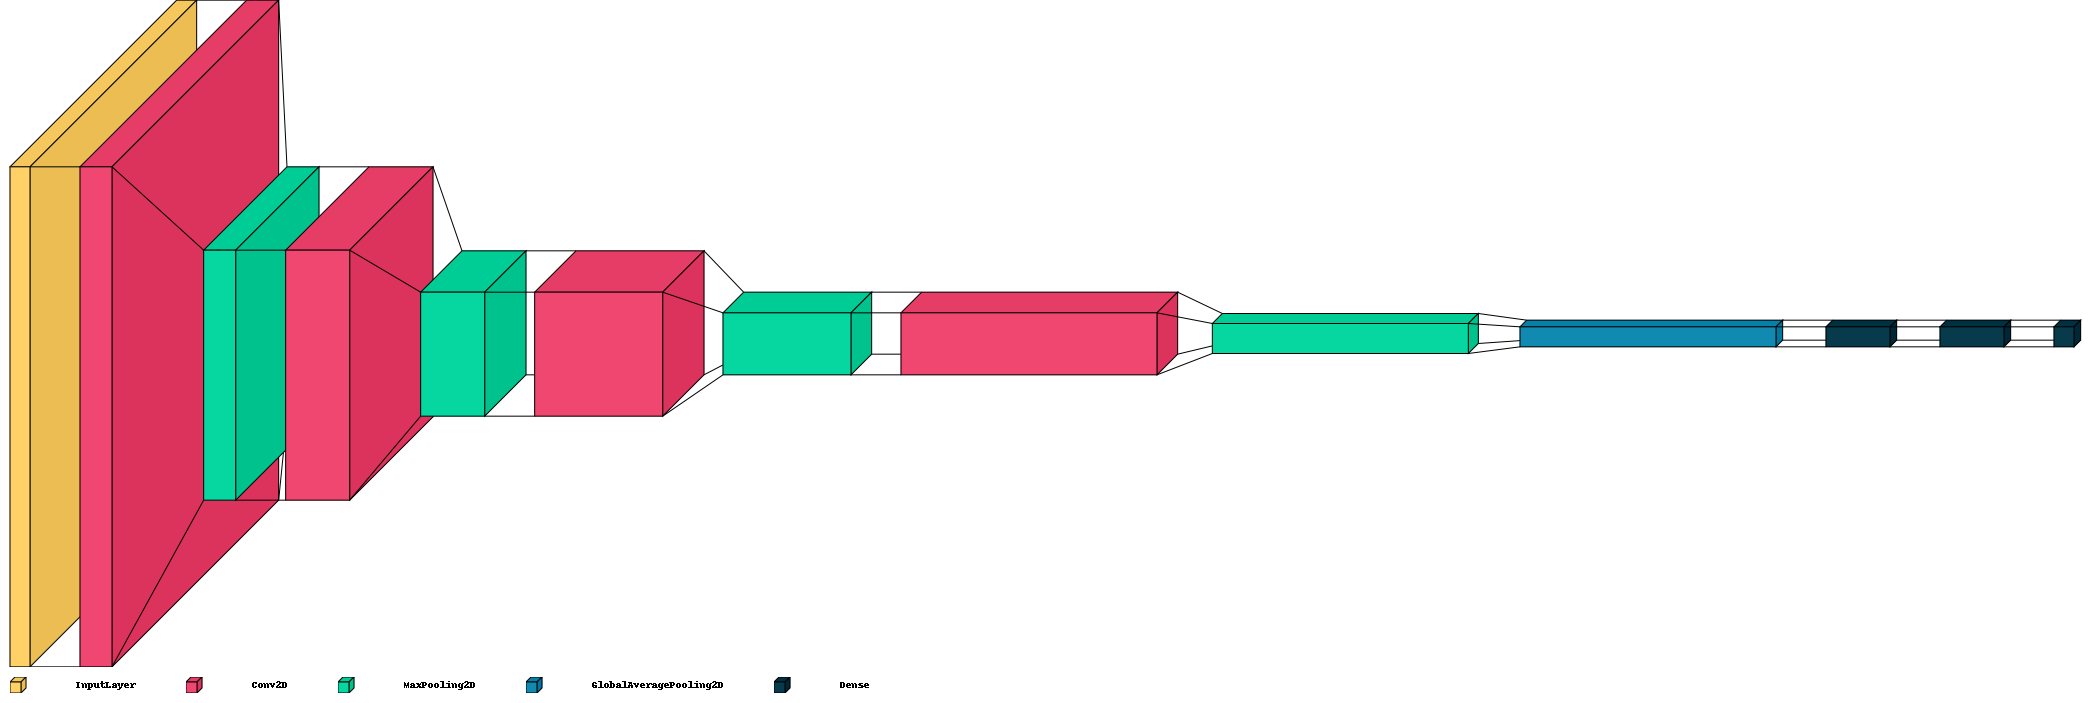

<Figure size 640x480 with 0 Axes>

In [10]:
#Plotting the model 

plt.figure(dpi = 100)
visualkeras.layered_view(model, spacing = 50,  scale_z = 1, scale_xy = 2 , legend=True, type_ignore=[BatchNormalization, Activation, Dropout])

# <span style="color:#e74c3c;"> Training </span> 


In [11]:
# Training

my_callbacks = [EarlyStopping(monitor = 'loss', patience = 8, min_delta = 0.0001)]

hist = model.fit(train_dataset, epochs = 100, verbose =1, callbacks = my_callbacks)

Epoch 1/100
319/319 [==============================] - 30s 17ms/step - loss: 0.6520 - accuracy: 0.6285 - auc: 0.6702 - precision: 0.6236 - recall: 0.6417
Epoch 2/100
319/319 [==============================] - 8s 16ms/step - loss: 0.6200 - accuracy: 0.6618 - auc: 0.7205 - precision: 0.6577 - recall: 0.6701
Epoch 3/100
319/319 [==============================] - 8s 16ms/step - loss: 0.5998 - accuracy: 0.6775 - auc: 0.7406 - precision: 0.6720 - recall: 0.6890
Epoch 4/100
319/319 [==============================] - 8s 17ms/step - loss: 0.5962 - accuracy: 0.6909 - auc: 0.7464 - precision: 0.6831 - recall: 0.7079
Epoch 5/100
319/319 [==============================] - 8s 16ms/step - loss: 0.5911 - accuracy: 0.6928 - auc: 0.7521 - precision: 0.6824 - recall: 0.7173
Epoch 6/100
319/319 [==============================] - 8s 16ms/step - loss: 0.5916 - accuracy: 0.6877 - auc: 0.7522 - precision: 0.6801 - recall: 0.7047
Epoch 7/100
319/319 [==============================] - 8s 16ms/step - loss: 0.576

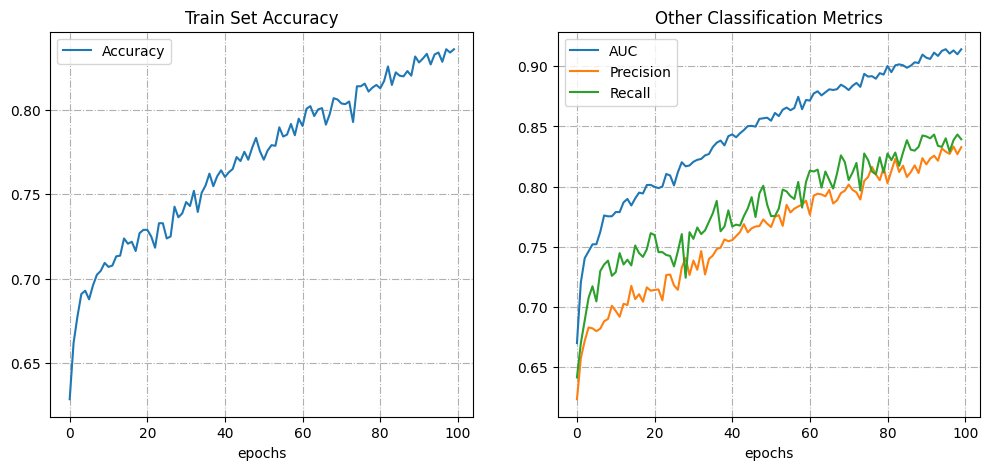

In [12]:
fig, axs = plt.subplots(1,2, figsize = (12,5), dpi = 100)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Train Set Accuracy")
axs[0].plot(hist.history['accuracy'])
axs[0].set_xlabel("epochs")
axs[0].legend(["Accuracy"])


axs[1].grid(linestyle="dashdot")
axs[1].set_title("Other Classification Metrics")
axs[1].plot(hist.history['auc'])
axs[1].plot(hist.history['precision'])
axs[1].plot(hist.history['recall'])
axs[1].set_xlabel("epochs")
axs[1].legend(["AUC", "Precision", "Recall"])


# <span style="color:#e74c3c;"> Test </span> Prediction, Evaluation


In [13]:
# Test set evaluation

test_eval = model.evaluate(test_dataset)

print('test accuracy : {0:.3f} %'.format(test_eval[1]*100))
print('test auc : {0:.3f}'.format(test_eval[2]))
print('test precision : {0:.3f}'.format(test_eval[3]))
print('test recall : {0:.3f}'.format(test_eval[4]))

57/57 [==============================] - 3s 43ms/step - loss: 0.4767 - accuracy: 0.8044 - auc: 0.8782 - precision: 0.8622 - recall: 0.7348
test accuracy : 80.444 %
test auc : 0.878
test precision : 0.862
test recall : 0.735


In [14]:
# Test set prediction

test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)
pred_ = np.round(pred)

y_test_take = []
for x in range(len(test_take1_)):
    y_test_take.extend(test_take1_[x][1].numpy())

57/57 [==============================] - 1s 11ms/step


# <span style="color:#e74c3c;"> Confusion </span> Matrix


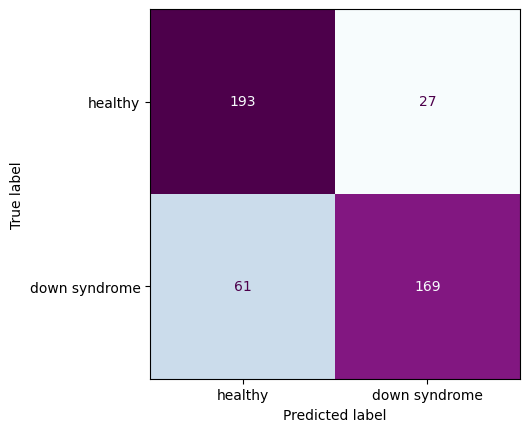

In [15]:
# Plotting the confusion matrix 

cm = confusion_matrix(y_test_take, pred_)
cmd = ConfusionMatrixDisplay(cm, display_labels= ['healthy','down syndrome'])
cmd.plot(cmap = 'BuPu',colorbar = False )

# <span style="color:#e74c3c;"> Classification </span> Report


In [16]:
# Classification report 

report = classification_report(np.array(y_test_take), pred_)
print(report)


              precision    recall  f1-score   support

           0       0.76      0.88      0.81       220
           1       0.86      0.73      0.79       230

    accuracy                           0.80       450
   macro avg       0.81      0.81      0.80       450
weighted avg       0.81      0.80      0.80       450

